In [ ]:

import boto3
import json
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse

import os

BUCKET = "amazonreviewsnlp"
VEC_PREFIX = "amazon_vectors/tfidf/"  
LOCAL_DIR = "../data/lsa_results"
os.makedirs(LOCAL_DIR, exist_ok=True)

s3 = boto3.client("s3")


In [10]:
# !pip install seaborn

In [ ]:

vec_path = f"{LOCAL_DIR}/vectors.npz"
vocab_path = f"{LOCAL_DIR}/vocab.json"

print("Downloading vectors from S3...")
s3.download_file(BUCKET, f"{VEC_PREFIX}vectors.npz", vec_path)

print("Downloading vocabulary...")
s3.download_file(BUCKET, f"{VEC_PREFIX}vocab.json", vocab_path)
X = sparse.load_npz(vec_path)   
with open(vocab_path, "r") as f:
    vocab = json.load(f)

print("Matrix shape:", X.shape)
print("Matrix type:", type(X))



Matrix shape: (10000, 1756)
Matrix type: <class 'scipy.sparse._csr.csr_matrix'>


In [ ]:

inv_vocab = {i: w for w, i in vocab.items()}


In [ ]:

n_components = 10   

svd = TruncatedSVD(n_components=n_components, n_iter=15, random_state=42)
lsa = make_pipeline(svd, Normalizer(copy=False))

X_lsa = lsa.fit_transform(X)

print("Explained variance ratio:", svd.explained_variance_ratio_.sum())


Explained variance ratio: 0.06840494810910092


In [ ]:

def top_terms(component_idx, top_n=20):
    comp = svd.components_[component_idx]
    term_indices = comp.argsort()[::-1][:top_n]
    terms = [(inv_vocab[i], comp[i]) for i in term_indices]
    return terms

for i in range(n_components):
    print(f"\n### LSA Topic {i} ###")
    for term, weight in top_terms(i, 20):
        print(f"{term:<20} {weight:.4f}")



### LSA Topic 0 ###
hair                 0.7075
skin                 0.2027
work                 0.1278
brush                0.1201
color                0.1114
long                 0.1089
quality              0.0993
price                0.0988
face                 0.0958
dry                  0.0877
feel                 0.0839
scent                0.0829
smell                0.0764
fine                 0.0762
make                 0.0746
smells               0.0696
shampoo              0.0669
day                  0.0653
small                0.0644
oil                  0.0643

### LSA Topic 1 ###
hair                 0.5936
curly                0.0321
fine hair            0.0312
hair hair            0.0290
clips                0.0272
long hair            0.0266
curly hair           0.0248
shampoo              0.0221
conditioner          0.0206
hold hair            0.0201
clip                 0.0200
hold                 0.0187
iron                 0.0181
curls                0.0175
comb  

In [ ]:

out_file = f"{LOCAL_DIR}/lsa_topics.txt"
with open(out_file, "w") as f:
    for i in range(n_components):
        f.write(f"\n### LSA Topic {i} ###\n")
        for term, weight in top_terms(i, 20):
            f.write(f"{term:<20} {weight:.4f}\n")

print("Saved:", out_file)


Saved: ../data/lsa_results/lsa_topics.txt


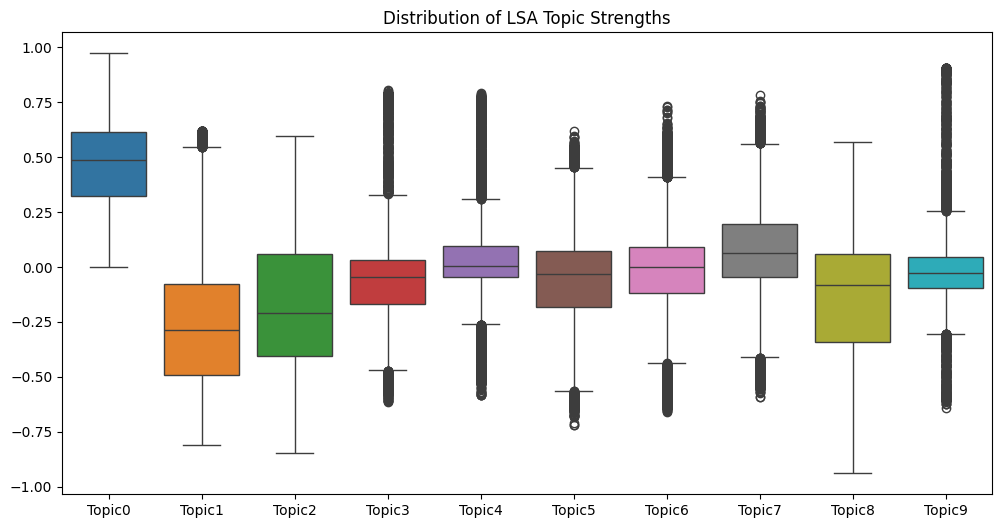

In [ ]:


topic_strengths = pd.DataFrame(
    X_lsa[:, :n_components],
    columns=[f"Topic{i}" for i in range(n_components)]
)

plt.figure(figsize=(12,6))
sns.boxplot(data=topic_strengths)
plt.title("Distribution of LSA Topic Strengths")
plt.show()
